# Titanic - Machine Learning from Disaster

## Imports

In [1117]:
# Common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklean packages
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

## Aquire Data

In [1118]:
train_data = pd.read_csv('datasets/raw/train.csv')
test_data = pd.read_csv('datasets/raw/test.csv')

def get_raw_data():
    return train_data.copy(), test_data.copy()

train_df, test_df = get_raw_data()
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##  Analyze the Data

### ToDo List

- ~'Cabin' feature contains too many NULL entries, so drop it!~
- ~Encode 'Embarked' and 'Sex' features.~
- ~'Age', 'Embarked' and 'Fare' features contains a few NULL entries, so maybe fill it with the Mean.~
- ~'Fare' feature contains a few obnormal entries, figure it out and fix it.~
- ~Drop 'PassengerId' if not relevant to survival rate.~
- 'SibSp' and 'Parch' features does not quite relate with survival rate, maybe try feature extraction?
- 'Name' is caegorical, maybe extract some useful information before dropping?
- 'Survived' feature must be seperated as they are the labels for out model.

### Analyze by describing the data

In [1119]:
# What are our features?
', '.join(list(train_df.columns))

'PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked'

In [1120]:
# Which features are categorical?
', '.join(list(train_df.select_dtypes('object').columns))

'Name, Sex, Ticket, Cabin, Embarked'

In [1121]:
# Which features are numerical?
', '.join(list(train_df.select_dtypes(exclude = ['object']).columns))

'PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare'

In [1122]:
# Which features contain empty entries?
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [1123]:
# What is the distribution of the data for numeric features?
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [1124]:
# What is the distribution of the data for categorical features
train_df.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Hagland, Mr. Konrad Mathias Reiersen",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


### Analyze by pivoting features

In [1125]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1126]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean()

# Conclusion: Pclass is very relevant to survival rate! Passengers on upper floors are most likly to have survived.

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [1127]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index = False).mean()

# Conclusion: Sex is also very relevant to survival rate! Females are most likely to have survived.

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [1128]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index = False).mean().sort_values(by = ['Survived'], ascending = False)

# Weird huh?

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [1129]:
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index = False).mean().sort_values(by = ['Survived'], ascending = False)

# Same as 'SibSp'

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [1130]:
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean()

# Conclutsion: Embarked is clearly an important factor!

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


### Analyze by visualizing the data

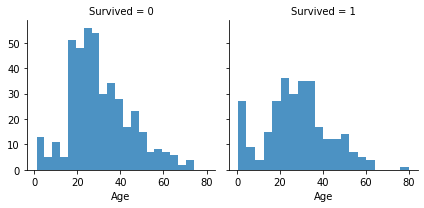

In [1131]:
graph = sns.FacetGrid(data = train_df, col = 'Survived')
graph.map(plt.hist, 'Age', bins = 20, alpha = 0.8)

# Conclusion: Age is obviously related to survival chance

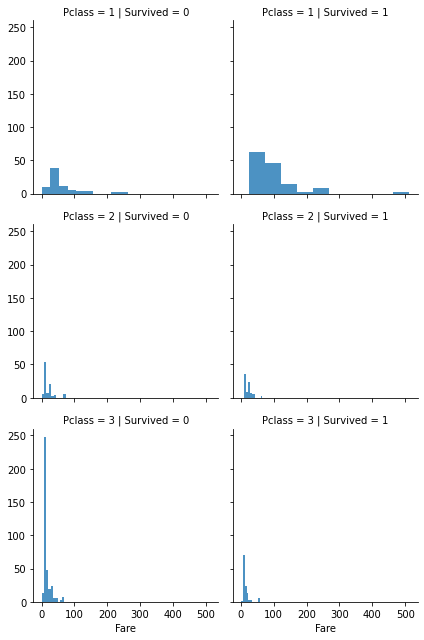

In [1132]:
graph = sns.FacetGrid(data = train_df, col = 'Survived', row = 'Pclass')
graph.map(plt.hist, 'Fare', alpha = 0.8)

# Conclusion: Fare is relevant, Pclass is too. So maybe Pclass and Fare are relevant as well?

## Data Preprocessing

In [1133]:
combined = [train_df, test_df]

### Drop the irrelevant feature

In [1134]:
# Save 'PassengerId' for the test_df for future reference
test_df_PassengerId = test_df['PassengerId']

for df in combined:
    df.drop(columns = ['Cabin', 'PassengerId', 'Ticket'], inplace = True)

### Fill 'Age', 'Embarked' and 'Fare' features

In [1135]:
for df in combined:
    df['Age'].fillna(value = df['Age'].mean(), inplace = True)
    df['Fare'].fillna(value = df['Fare'].mean(), inplace = True)
    df['Embarked'].fillna(value = 'S', inplace = True)

### Encode 'Embarked' and 'Sex' features

In [1136]:
for df in combined:
    encoder = LabelEncoder()
    
    df['Embarked'] = encoder.fit_transform(df['Embarked'])
    df['Sex'] = encoder.fit_transform(df['Sex'])

### Fix 'Fare' feature obnormal entries

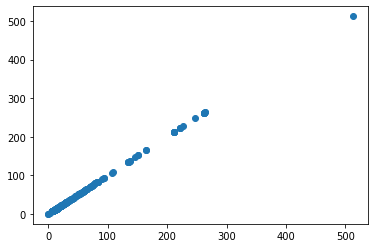

In [1137]:
plt.scatter(test_df['Fare'], test_df['Fare'])

for df in combined:
    df = df[df['Fare'] < 400]

### Feature Extraction

#### 'SibSp' and 'Parch' features

In [1138]:
for df in combined:    
    # Create a 'Family' feature
    df['Family'] = df['SibSp'] + df['Parch'] + 1
    
    # Create a 'isAlone' feature
    df['isAlone'] = 0
    df.loc[df['Family'] == 1, 'isAlone'] = 1
    
    # Drop 'Parch' and 'SibSp' features
    df.drop(columns = ['SibSp', 'Parch'], inplace = True)

train_df[['Survived', 'isAlone']].groupby(by = ['isAlone'], as_index = False).mean()

,isAlone,Survived
0,0,0.505650
1,1,0.303538


#### 'Name' feature

In [1139]:
for df in combined:
    
    # Create new feature
    df['Title'] = df['Name'].str.extract(r'([A-Za-z]+)\.', expand = False)
    
    # Correcy spellings
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    # Encode
    encoder = LabelEncoder()
    df['Title'] = encoder.fit_transform(df['Title'])
    
    # Safely remove 'Name' feature
    df.drop(columns = ['Name'], inplace = True)

# train_df[['Title', 'Survived']].groupby('Title', as_index = False).mean().sort_values(by = ['Survived'], ascending = False)
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family,isAlone,Title
0,0,3,1,22.0,7.2500,2,2,0,10
1,1,1,0,38.0,71.2833,0,2,0,11
2,1,3,0,26.0,7.9250,2,1,1,9
3,1,1,0,35.0,53.1000,2,2,0,11
4,0,3,1,35.0,8.0500,2,1,1,10


#### 'Age' feature extraction

In [1140]:
def slice_age(combined, n_slices = 7):
    for df in combined:
    
        # Slice
        df['AgeBand'] = pd.cut(df['Age'], n_slices)
    
        # Encode
        encoder = LabelEncoder()
        df['AgeBand'] = encoder.fit_transform(df['AgeBand'])
        
        # Safely drop 'Age'
        df.drop(columns = ['Age'], inplace = True)

slice_age(combined, n_slices = 7)
train_df[['AgeBand', 'Survived']].groupby(by = ['AgeBand'], as_index = False).mean()

,AgeBand,Survived
0,0,0.573529
1,1,0.359551
2,2,0.353659
3,3,0.417910
4,4,0.411765
5,5,0.346154
6,6,0.142857


#### 'Fare' feature

In [1141]:
def slice_fare(combined, n_slices = 4):
    for df in combined:
    
        # Q-Slice
        df['FareBand'] = pd.qcut(df['Fare'], n_slices)
    
        # Encoder
        encoder = LabelEncoder()
        df['FareBand'] = encoder.fit_transform(df['FareBand'])
        
        # Safely drop 'Fare'
        df.drop(columns = ['Fare'], inplace = True)

slice_fare(combined, n_slices = 4)
train_df[['FareBand', 'Survived']].groupby(by = ['FareBand'], as_index = False).mean()

,FareBand,Survived
0,0,0.197309
1,1,0.303571
2,2,0.454955
3,3,0.581081


## Save Preprocessed dataset

In [1142]:
train_df.to_csv('datasets/processed/train.csv')
test_df.to_csv('datasets/processed/test.csv')

## Split Data

In [1143]:
X_train = train_df.loc[:, train_df.columns != 'Survived']
y_train = train_df['Survived']

X_test = test_df.loc[:, test_df.columns != 'Survived']

## Define Models

### SVC

In [1144]:
svc = SVC()

svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

svc_acc = round(svc.score(X_train, y_train) * 100, 3)
svc_acc

79.798

### KNN

In [1145]:
knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

knn_acc = round(knn.score(X_train, y_train) * 100, 3)
knn_acc

81.818

### Gaussian Naive Bayes

In [1146]:
guassian = GaussianNB()

guassian.fit(X_train, y_train)
guassian_pred = guassian.predict(X_test)

guassian_acc = round(guassian.score(X_train, y_train) * 100, 3)
guassian_acc

78.002

### Perceptron

In [1147]:
perceptron = Perceptron()

perceptron.fit(X_train, y_train)
perceptron_pred = perceptron.predict(X_test)

perceptron_acc = round(perceptron.score(X_train, y_train) * 100, 3)
perceptron_acc

72.727

### Linear SVC

In [1148]:
linear_svc = SVC()

linear_svc.fit(X_train, y_train)
linear_svc_pred = linear_svc.predict(X_test)

linear_svc_acc = round(linear_svc.score(X_train, y_train) * 100, 3)
linear_svc_acc

79.798

### Stochastic Gradient Descent

In [1149]:
sgd = SGDClassifier()

sgd.fit(X_train, y_train)
sgd_pred = sgd.predict(X_test)

sgd_acc = round(sgd.score(X_train, y_train) * 100, 3)
sgd_acc

47.587

### Decision Tree

In [1150]:
decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train, y_train)
decision_tree_pred = decision_tree.predict(X_test)

decision_tree_acc = round(decision_tree.score(X_train, y_train) * 100, 3)
decision_tree_acc

89.562

### Random Forest

In [1151]:
random_forest = RandomForestClassifier(n_estimators = 100)

random_forest.fit(X_train, y_train)
random_forest_pred = random_forest.predict(X_test)

random_forest_acc = round(random_forest.score(X_train, y_train) * 100, 3)
random_forest_acc

89.562

### LogisticRegression

In [1152]:
log = LogisticRegression()

log.fit(X_train, y_train)
log_pred = log.predict(X_test)

log_acc = round(log.score(X_train, y_train) * 100, 3)
log_acc

80.022

### XGBoost

In [1153]:
gxb = XGBClassifier(use_label_encoder = False)

gxb.fit(X_train, y_train)
gxb_pred = gxb.predict(X_test)

gxb_acc = round(gxb.score(X_train, y_train) * 100, 3)
gxb_acc

[11:31:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


e:\installation root\python 3.8.7\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


88.889

## Evaluation

In [1154]:
models = pd.DataFrame({
    'Model': ['SVC', 'KNN', 'Naive Bayes', 'Perceptron', 'Linear SVC',
              'Stochastic Gradient Decent', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'XGBoost'],

    'Score': [svc_acc, knn_acc, guassian_acc, perceptron_acc, linear_svc_acc,
              sgd_acc, decision_tree_acc, random_forest_acc, log_acc, gxb_acc]})

models.sort_values(by = 'Score', ascending = False)

,Model,Score
6,Decision Tree,89.562
7,Random Forest,89.562
9,XGBoost,88.889
1,KNN,81.818
8,Logistic Regression,80.022
0,SVC,79.798
4,Linear SVC,79.798
2,Naive Bayes,78.002
3,Perceptron,72.727
5,Stochastic Gradient Decent,47.587


### Cross-Validation

In [1155]:
models = [svc, knn, guassian, perceptron, linear_svc, sgd, decision_tree, random_forest, log]
cv_results = []

for model in models:
    cv_result = cross_validate(model, X_train, y_train, cv = 5)
    cv_results.append(cv_result['test_score'].mean())

cv_df = pd.DataFrame({
    'Model': ['SVC', 'KNN', 'Naive Bayes', 'Perceptron', 'Linear SVC',
              'Stochastic Gradient Decent', 'Decision Tree', 'Random Forest', 'Logistic Regression'],

    'Score': cv_results
})

cv_df.sort_values(by = 'Score', ascending = False)

,Model,Score
7,Random Forest,0.804764
6,Decision Tree,0.795750
0,SVC,0.794595
4,Linear SVC,0.794595
8,Logistic Regression,0.787910
1,KNN,0.781169
2,Naive Bayes,0.773373
5,Stochastic Gradient Decent,0.740713
3,Perceptron,0.718329


## Submission

In [1156]:
submission = pd.DataFrame({
    'PassengerId': test_df_PassengerId,
    'Survived': random_forest_pred
})

submission.to_csv('datasets/processed/submission.csv', index = False)